# Load and Clean Dataset
This notebook is run on a cluster from IBM Watson. It contains a midium size subset (256MB) of the full dataset (12GB). The loading part depends on your environment. 

In [1]:

import ibmos2spark, os
from pyspark.sql.functions import avg, col, concat, count, countDistinct, desc, explode, lit, min, max, sum, split, stddev, udf, when, lag, isnull
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql import Window

import time
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#set seaborn style
sns.set(style="whitegrid")
# @hidden_cell

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_e742e3bd425e46d38f014ebdef88a08a = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_e742e3bd425e46d38f014ebdef88a08a = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

credentials = {
    'endpoint': endpoint_e742e3bd425e46d38f014ebdef88a08a,
    'service_id': 'iam-ServiceId-50c3394f-1ffd-4ff1-b04a-18ecf041e06c',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'i1fYzUtHA_tNgpbEEg2Q0PD5Blw_nqnbP4wG1ESEhl7G'
}

configuration_name = 'os_e742e3bd425e46d38f014ebdef88a08a_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-ipndny6fyhouwb'))
df.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210323064340-0000
KERNEL_ID = 3788d7f3-38ae-4625-9efc-b07ac9cf7017


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [2]:
df.printSchema()
print('Shape of Dataset: ' ,(df.count(), len(df.columns)))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

Shape of Dataset:  (543705, 18)


In [3]:
def count_missings(spark_df):
    spark_df.select([count(when(isnull(c), c)).alias(c) for c in spark_df.columns]).show()

count_missings(df)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [4]:
df = df.where(df.userId != "")
count_missings(df)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95128|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



# Exploratory Data Analysis
We can find out what events users have done through the page feature. As it is a music streaming service, the most frequent event is music playback, followed by upvoting, visiting the homepage, and adding a playlist, etc.

(0.0, 100000.0)

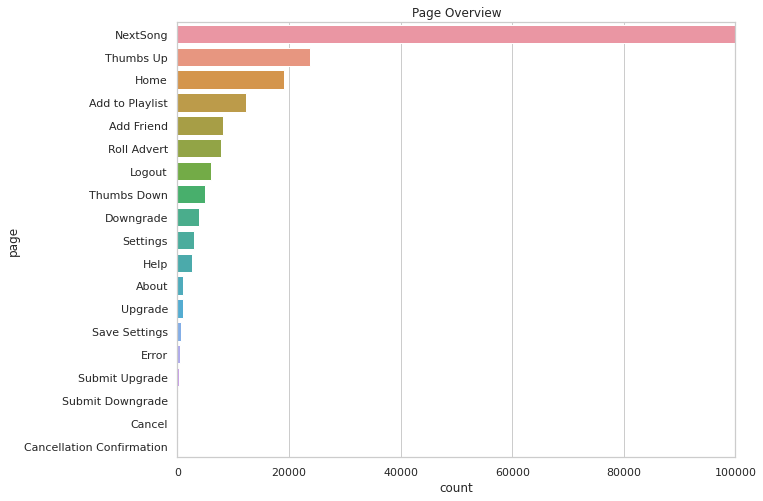

In [5]:
f, ax = plt.subplots(figsize=(10, 8))
ax.set(title="Page Overview")
sns.barplot(y='page', x='count',data=df.groupBy('page').count().orderBy(col('count').desc()).toPandas())
ax.set_xlim(0,100000)

We can also check the distribution of paid and free users by gender and browser.

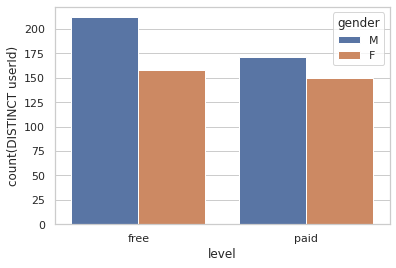

In [6]:
sns.barplot(x='level',y='count(DISTINCT userId)',hue='gender', data=df.groupBy('level','gender').agg(countDistinct('userId')).toPandas())

In [7]:
df.groupBy('level','gender').agg(countDistinct('userId')).toPandas().head()

,level,gender,count(DISTINCT userId)
0,free,M,212
1,paid,M,171
2,paid,F,150
3,free,F,158


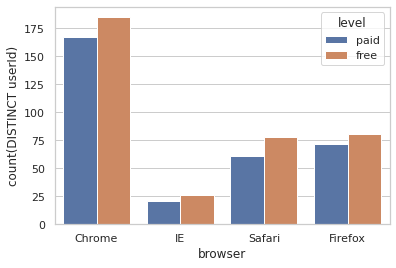

In [8]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN
    
browser = udf(lambda x: get_browser(x))
df = df.withColumn('browser', browser(df.userAgent))

sns.barplot(x='browser',y='count(DISTINCT userId)',hue='level', data=df.groupBy('browser','level').agg(countDistinct('userId')).toPandas())

# Feature Engineering

## Preprocess data

- The user who has visited the cancellation confirmation page is defined as churned user.
- Categorical features are replaced with numerical features with a value of 0 or 1 through one-hot-encoding. 
- The timestamped raw data stored each time an event occurs are aggregated by each session. Information such as the number of songs played per session, the number of upvotings, the number of playlists added, and the duration of the session are extracted. 
- The aggregated data for each session is again aggregated for each user so that every user has one row record. The average number of songs played per session and the average number of playlists added per session are extracted. In addition, in order to include information on changes in user behavior over time, the features containing only recent behavior such as the number of songs played in the last two weeks were separately extracted.

In [9]:
df = df.withColumn('cancel', when(df.page == 'Cancellation Confirmation', 1).otherwise(0)) \
    .withColumn('thumpsup', when(df.page == 'Thumbs Up', 1).otherwise(0)) \
    .withColumn('thumpsdown', when(df.page == 'Thumbs Down', 1).otherwise(0)) \
    .withColumn('ad', when(df.page == 'Roll Advert', 1).otherwise(0)) \
    .withColumn('playlist', when(df.page == 'Add to Playlist', 1).otherwise(0)) \
    .withColumn('friend', when(df.page == 'Add Friend', 1).otherwise(0)) \
    .withColumn('error', when(df.page == 'Error', 1).otherwise(0)) \
    .withColumn('home', when(df.page == 'Home', 1).otherwise(0)) \
    .withColumn('downgrade', when(df.page == 'Downgrade', 1).otherwise(0)) \
    .withColumn('upgrade', when(df.page == 'Upgrade', 1).otherwise(0)) \
    .withColumn('setting', when(df.page == 'Save Settings', 1).otherwise(0)) \
    .withColumn('ts', col('ts')/1000) \
    .withColumn('registration', col('registration')/1000) \
    .withColumn('day', ((col('ts')-col('registration'))/(60*60*24)).cast(IntegerType()))

- The raw data will be grouped by user id and session id.

In [10]:


sessions = df.groupBy('userId', 'sessionId').agg(count('song').alias('play'),
                                                 max('cancel').alias('churn'),
                                                 min('day').alias('day'),
                                                 min('ts').alias('start'),
                                                 max('ts').alias('end'),                                                 
                                                 max('level').alias('level'),
                                                 max('gender').alias('gender'),
                                                 max('browser').alias('browser'),
                                                 sum('thumpsup').alias('thumpsup'),
                                                 sum('thumpsdown').alias('thumpsdown'),
                                                 sum('ad').alias('ads'),
                                                 sum('playlist').alias('playlists'),
                                                 sum('friend').alias('friends'),
                                                 sum('error').alias('errors'),
                                                 sum('setting').alias('setting')) \
    .withColumn('duration', (col('end') - col('start')).cast(IntegerType()))


windowSpec = Window.partitionBy('userId').orderBy('start')
userWindow = Window.partitionBy('userId')

#how many days passed between sessions
sessions = sessions.withColumn('gap', col('day') - lag('day', 1, 0).over(windowSpec))
sessions = sessions.withColumn('churn', max('churn').over(userWindow))
sessions = sessions.withColumn('last', max('day').over(userWindow))

- The grouped session data will be aggreated for each user. Finally we will get one aggregated row for each user.

In [11]:
users = sessions.groupBy('userId').agg(count('sessionId').alias('total_session'),
                                       avg('play').alias('avg_play'),
                                       when(count('play') > 1, stddev('play')).otherwise(0).alias('std_play'),
                                       avg('thumpsup').alias('avg_up'),
                                       avg('thumpsdown').alias('avg_down'),
                                       avg('ads').alias('avg_ads'),
                                       avg('setting').alias('avg_setting'),
                                       avg('playlists').alias('avg_playlists'),
                                       avg('friends').alias('avg_friends'),
                                       avg('duration').alias('avg_duration'),
                                       when(count('duration') > 1, stddev('duration')).otherwise(0).alias('std_duration'), 
                                       avg('gap').alias('avg_gap'),
                                       when(count('gap') > 1, stddev('gap')).otherwise(0).alias('std_gap'),
                                       max('day').alias('life_time'),
                                       max('churn').alias('label'))

recent = sessions.where(sessions.day>(sessions.last-14)).groupBy('userId') \
                                  .agg(when(count('sessionId')>0, avg('play')).otherwise(0).alias('recent_play'),
                                       when(count('play') > 1, stddev('play')).otherwise(0).alias('recent_std_play'),
                                       when(count('sessionId')>0,avg('thumpsup')).otherwise(0).alias('recent_up'),
                                       when(count('sessionId')>0,avg('thumpsdown')).otherwise(0).alias('recent_down'),
                                       when(count('sessionId')>0,avg('ads')).otherwise(0).alias('recent_ads'),
                                       when(count('sessionId')>0,avg('setting')).otherwise(0).alias('recent_setting'),
                                       when(count('sessionId')>0,avg('playlists')).otherwise(0).alias('recent_playlists'),
                                       when(count('sessionId')>0,avg('friends')).otherwise(0).alias('recent_friends'),
                                       when(count('sessionId')>0,avg('duration')).otherwise(0).alias('recent_duration'),
                                       when(count('sessionId')>0,avg('gap')).otherwise(0).alias('recent_gap'),
                                       when(count('gap') > 1, stddev('gap')).otherwise(0).alias('recent_std_gap'))




users = users.join(recent, on='userId')                                                             

- Visualize how some extracted features are distributed according to the label.

[Text(0, 0.5, ''),
 Text(0.5, 0, 'churn'),
 Text(0.5, 1.0, 'Average recent up per session')]

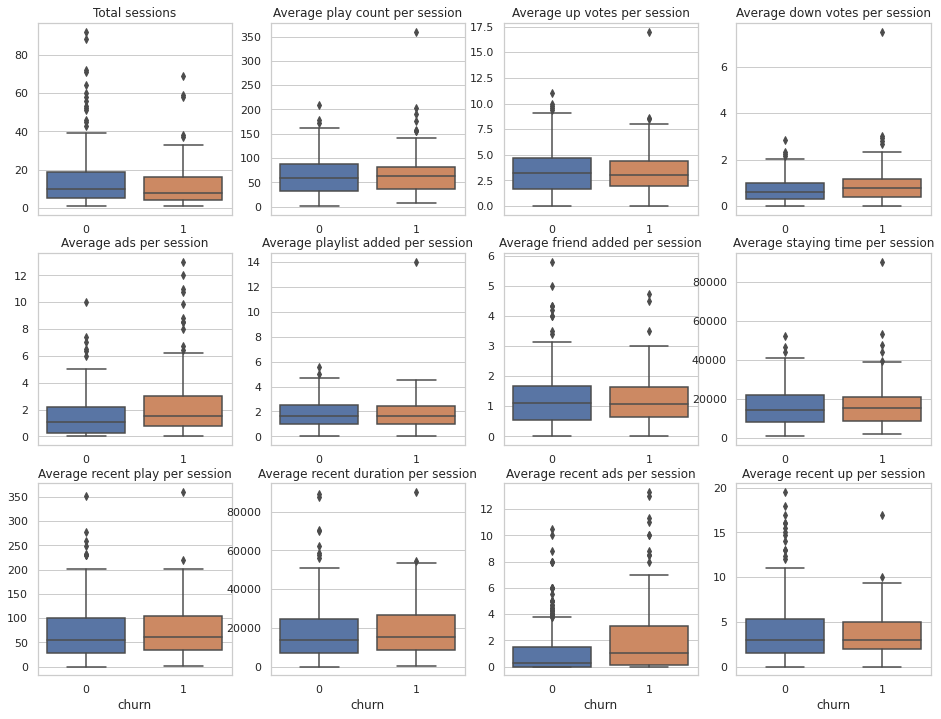

In [12]:
pd_users =users.select("userId", "total_session","avg_play","std_play","avg_up","avg_down","avg_ads","avg_playlists",
                       "avg_friends","avg_duration","std_duration","avg_gap","std_gap",
                       "recent_play", "recent_duration","recent_ads","recent_up","label").toPandas()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sns.boxplot(ax=axes[0,0], x="label", y="total_session", data=pd_users)
axes[0,0].set(title="Total sessions", xlabel='',ylabel='')

sns.boxplot(ax=axes[0,1], x="label", y="avg_play", data=pd_users)
axes[0,1].set(title="Average play count per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[0,2], x="label", y="avg_up", data=pd_users)
axes[0,2].set(title="Average up votes per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[0,3], x="label", y="avg_down", data=pd_users)
axes[0,3].set(title="Average down votes per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[1,0], x="label", y="avg_ads", data=pd_users)
axes[1,0].set(title="Average ads per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[1,1], x="label", y="avg_playlists", data=pd_users)
axes[1,1].set(title="Average playlist added per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[1,2], x="label", y="avg_friends", data=pd_users)
axes[1,2].set(title="Average friend added per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[1,3], x="label", y="avg_duration", data=pd_users)
axes[1,3].set(title="Average staying time per session", xlabel='',ylabel='')

sns.boxplot(ax=axes[2,0], x="label", y="recent_play", data=pd_users)
axes[2,0].set(title="Average recent play per session", xlabel='churn',ylabel='')

sns.boxplot(ax=axes[2,1], x="label", y="recent_duration", data=pd_users)
axes[2,1].set(title="Average recent duration per session", xlabel='churn',ylabel='')

sns.boxplot(ax=axes[2,2], x="label", y="recent_ads", data=pd_users)
axes[2,2].set(title="Average recent ads per session", xlabel='churn',ylabel='')

sns.boxplot(ax=axes[2,3], x="label", y="recent_up", data=pd_users)
axes[2,3].set(title="Average recent up per session", xlabel='churn',ylabel='')




# Modeling
## baseline classifier
First, let's check four representative classifiers such as logistic regression, decision tree, random forest, and gradient boosting tree without tuning hyperparameters to get a baseline. Since the churned users are a fairly small subset, we are using F1 score as the metric to optimize.
1. Split dataset into training set and test set
2. Building a pipeline that performs vectorization of the dataset using Vector Assembler, normalization of the dataset using StandardScaler and classification of the dataset using different classifiers without tuning hyper-parameters to get a baseline
3. Fit pipeline on training set
4. Predict data on test set
5. Evaluate model on f1 score

In [18]:
import time
SEED=1234
# Split the data into train and test subsets
train, test = users.randomSplit([0.8, 0.2], seed=SEED)

assembler = VectorAssembler(inputCols=["total_session",
                                       "avg_play",
                                       "std_play",
                                       "avg_up",
                                       "avg_down",
                                       "avg_ads",
                                       "avg_setting",
                                       "avg_playlists",
                                       "avg_friends",
                                       "avg_duration",
                                       "std_duration",
                                       "avg_gap",
                                       "std_gap",
                                       "life_time",
                                       "recent_play",
                                       "recent_std_play",
                                       "recent_up",
                                       "recent_down",
                                       "recent_ads",
                                       "recent_setting",
                                       "recent_playlists",
                                       "recent_friends",
                                       "recent_duration",
                                       "recent_gap",
                                       "recent_std_gap"
                                      ], outputCol="NumFeatures")

scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [24]:
def check_baseline():
    lr = LogisticRegression()
    dt = DecisionTreeClassifier(seed=SEED)
    rf = RandomForestClassifier(featuresCol="features")
    gbt = GBTClassifier(featuresCol="features", maxIter=10)
    
    for clf in [lr, dt, rf, gbt]:
        clf_name = clf.__class__.__name__
        pipeline = Pipeline(stages=[assembler, scaler, clf])
        #crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=ParamGridBuilder().build(), evaluator=f1_score_evaluator)

        stime = time.time()
        model = pipeline.fit(train)
        etime = time.time()
        train_time = round(etime-stime, 2)
        
        
        pred_train = model.transform(train)
        f1_score_train = f1_score_evaluator.evaluate(pred_train.select('label','prediction'),{f1_score_evaluator.metricName: 'f1'})
        
        pred_test = model.transform(test)
        f1_score = f1_score_evaluator.evaluate(pred_test.select('label','prediction'),{f1_score_evaluator.metricName: 'f1'})
        
        print("Fitting {} model took {} sec".format(clf_name, train_time))
        print('The F1 score on the train set is {:.2%}'.format(f1_score_train))
        print('The F1 score on the test set is {:.2%}'.format(f1_score))
        print(" ")
        
check_baseline()

Fitting LogisticRegression model took 146.39 sec
The F1 score on the train set is 77.24%
The F1 score on the test set is 79.50%
 
Fitting DecisionTreeClassifier model took 67.74 sec
The F1 score on the train set is 90.48%
The F1 score on the test set is 78.15%
 
Fitting RandomForestClassifier model took 79.79 sec
The F1 score on the train set is 85.82%
The F1 score on the test set is 82.82%
 
Fitting GBTClassifier model took 184.83 sec
The F1 score on the train set is 97.97%
The F1 score on the test set is 81.21%
 


## Fine tune the selected model
As we can see above, the random forest model works best. Now we tune hyperparameters for random forest model. I use a cross-validation method to avoid overfitting and get more general results.

In [20]:
clf = RandomForestClassifier(featuresCol="features")
pipeline = Pipeline(stages=[assembler, scaler, clf])

paramGrid = ParamGridBuilder() \
            .addGrid(clf.maxDepth, [10, 20]) \
            .addGrid(clf.numTrees, [20, 80]) \
            .addGrid(clf.maxBins, [16, 64]).build()

crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds=3)

cvModel = crossval.fit(train)


cvModel.avgMetrics

[0.7615217892733916,
 0.7467538623337331,
 0.7628579460598245,
 0.7655390400878661,
 0.7634270627993468,
 0.7459176117863207,
 0.767113616603928,
 0.7680531229511649]

In [21]:
pred_test = cvModel.transform(test)
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(pred_test.select('label','prediction'),{f1_score_evaluator.metricName: 'f1'})

print('The F1 score of the fine-tuned model on the test set is {:.2%}'.format(f1_score))

The F1 score of the fine-tuned model on the test set is 84.33%


# Conclusion

In [22]:
inputCols=["total_session", "avg_play","std_play","avg_up","avg_down","avg_ads","avg_setting","avg_playlists",
           "avg_friends","avg_duration","std_duration","avg_gap","std_gap","life_time","recent_play",
                                       "recent_std_play",
                                       "recent_up",
                                       "recent_down",
                                       "recent_ads",
                                       "recent_setting",
                                       "recent_playlists",
                                       "recent_friends",
                                       "recent_duration",
                                       "recent_gap",
                                       "recent_std_gap"]
# print feature importances
for i in range(len(cvModel.bestModel.stages[-1].featureImportances)):
    print("{} : {} \n".format(inputCols[i], cvModel.bestModel.stages[-1].featureImportances[i]))



total_session : 0.05678154464261352 

avg_play : 0.03780571314679637 

std_play : 0.026241145937656047 

avg_up : 0.024968237693213116 

avg_down : 0.027669528635739165 

avg_ads : 0.05309722571894887 

avg_setting : 0.018358336222781307 

avg_playlists : 0.02903820089478811 

avg_friends : 0.03364018829068995 

avg_duration : 0.03537054320669622 

std_duration : 0.023487774985539986 

avg_gap : 0.04847152950436505 

std_gap : 0.05690156341042187 

life_time : 0.11680030334219353 

recent_play : 0.031296027277776466 

recent_std_play : 0.03653206034806208 

recent_up : 0.03244230780246264 

recent_down : 0.03272758369263713 

recent_ads : 0.05339544547500039 

recent_setting : 0.008763621019442922 

recent_playlists : 0.029088844562716824 

recent_friends : 0.037863881741692355 

recent_duration : 0.028678782730128104 

recent_gap : 0.07823223450686943 

recent_std_gap : 0.04234737521076868 



The F1 score of the best model is 88.62%, and it looks reasonable. I think there is room for improvement through ensembles with other models and more hyperparameters tuning. 

Also, it is practically not useful to predict churning with a whole records including right before churn. We need to predict churning in advance, for example, 30 days before the cancellation, to take proactive actions. For this reason, the data from 30 days before the last session could be excluded.

The last thing I want to mention is the importance of trend-related information. Because user interactions and attitudes toward the service change over time, we need to analyze what events occur in a particular time frame and how it changes over time. However, the analysis here seems to have limitations in this part. More specifically, in the process of aggregating the number of time series data into one record per user, the trend-related information would be missing.  Of course, the features of the last 14 days have been selected to prevent missing the information, but it might be insufficient. There is a possibility that we will get better performance if we include more trend-related features, or if we even use all the raw data without an aggregation process.